In [1]:
#!pip install --user numpy pandas matplotlib wandb tqdm

In [2]:
#!pip install --user torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
#!pip install --user torch-fidelity

In [4]:
import os
import math
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

from torch_fidelity import calculate_metrics

import wandb
from tqdm.notebook import tqdm

# Preprocessing

## cuda check

In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
display(train_on_gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True

## Load CIFAR10 dataset

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

## WandB login

In [4]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: floowbaumgartner (floow-fhnw). Use `wandb login --relogin` to force relogin


True

## EDA

Number of images per label in CIFAR-10 Trainset:
airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


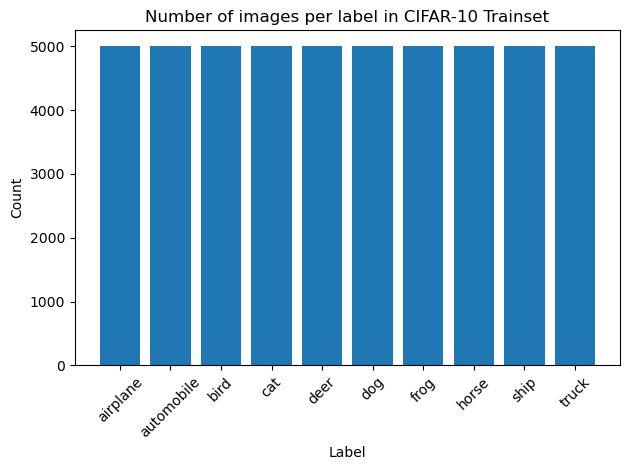

In [5]:
labels = trainset.targets
label_counts = Counter(labels)

label_names = trainset.classes
label_count_named = {label_names[i]: label_counts[i] for i in range(len(label_names))}

print("Number of images per label in CIFAR-10 Trainset:")
for label, count in label_count_named.items():
    print(f"{label}: {count}")

plt.bar(label_count_named.keys(), label_count_named.values())
plt.title("Number of images per label in CIFAR-10 Trainset")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# simple diffusion model

## structure

In [24]:
def get_images_by_label(dataset, target_label, num_samples=1):
    '''
    Retrieves `num_samples` images from `dataset` that have the label `target_label`.
    '''
    images_same_label = []

    # Iterate over the dataset to find images with the desired label
    for img, label in dataset:
        if label == target_label:
            images_same_label.append(img)
        if len(images_same_label) == num_samples:
            break

    # Stack the list of images into a single tensor
    if len(images_same_label) > 0:
        images_overfit = torch.stack(images_same_label)
        return images_overfit
    else:
        return torch.empty(0)

In [27]:
images_overfit = get_images_by_label(trainset, 1, 1)
images_overfit.shape

torch.Size([1, 3, 32, 32])

### forward process (Noise sheduler)

the goal is to sample an image at a timestamp $t$ and deliver it to the model. this makes the training much easier and smoother as the model can learn to denoise the image at each timestep, compared to sequently iterating over the same image over and over again.
first, i have to define a function to create a linear beta schedule, which determines the amount of noise added at each time step. With the a helper function `get_index_from_list` i extract a specific index $t$ from a list of values, so i can handle the batch dimension. And for the calculation of the noisy image i need to precompute various terms (like $alpha_t$, $alpha_{cumprod}$, etc.) that will be used in the diffusion process. The `forward_diffusion_sample` function takes the image, timestep and pre calculated terms to return a noisy version of it.

In [28]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Create a linear beta schedule for the diffusion model. it is used to calculate the noise level at each timestep.
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension. (helperfunction)
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod,device="gpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0) #sample noise
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

def precompute_terms(betas):
    """
    Precomputes terms required to calculate the noisy version of an image
    """
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    return {
        "alphas": alphas,
        "alphas_cumprod": alphas_cumprod,
        "alphas_cumprod_prev": alphas_cumprod_prev,
        "sqrt_recip_alphas": sqrt_recip_alphas,
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,
        "posterior_variance": posterior_variance
    }

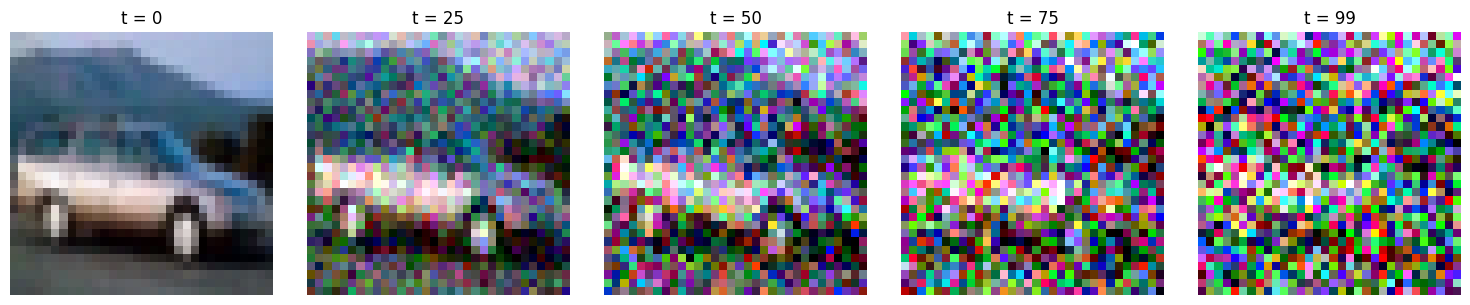

In [29]:
# time steps
T = 100
# create beta schedule
betas = linear_beta_schedule(timesteps=T)
# precompute terms
terms = precompute_terms(betas)
# define timesteps for visualization
timesteps_to_sample = [0, 25, 50, 75, 99]

# ectract single overfit image
x_0 = images_overfit[0].unsqueeze(0) # shape: (1, C, H, W)

# Generate noisy samples at the selected timesteps
noisy_images = []
for t_val in timesteps_to_sample:
    t_tensor = torch.tensor([t_val], dtype=torch.long)
    noisy_img, _ = forward_diffusion_sample(
        x_0, 
        t_tensor, 
        terms["sqrt_alphas_cumprod"], 
        terms["sqrt_one_minus_alphas_cumprod"], 
        device="cpu"
    )
    noisy_images.append(noisy_img[0]) # Remove batch dimension

# Helper function to denormalize and convert tensor for plotting
def denormalize_and_to_numpy(tensor_image):
    """
    Denormalizes and converts a tensor image to numpy for plotting.(helperfunction)
    """
    # The original transform was Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    # therefore apply the inverse transform: image * 0.5 + 0.5
    image = tensor_image.clone().detach()
    image = (image * 0.5) + 0.5
    # Clamp to [0,1] for plotting in rgb
    image = image.clamp(0,1)
    # Convert from Channels,Hight,Width (C,H,W) to H,W,C and to numpy
    image_np = image.permute(1,2,0).cpu()
    return image_np


# Plot the original and noisy samples
fig, axes = plt.subplots(1, len(timesteps_to_sample), figsize=(15, 3))
for ax, img, t in zip(axes, noisy_images, timesteps_to_sample):
    ax.imshow(denormalize_and_to_numpy(img))
    ax.set_title(f"t = {t}")
    ax.axis("off")

plt.tight_layout()
plt.show()

Above is sample of how a image looks in diffrent timesteps ($t$) with added more noise when $t$ gets higher. $T$ is set to 100.

### Simple Diffusion

Below is a `Block` class used in the U-Net. This block handles the convolutional layers as well as the time embedding addition.
It can be configured for downsampling or upsampling depending on the parameter `up`. For the timeembedding i define a class to
produce sinusoidal embeddings for the time step. These embeddings help the model incorporate the notion of time step into its layers.

In [10]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
            
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        #self.bnorm1 = nn.BatchNorm2d(out_ch) #changed to groupnorm
        #self.bnorm2 = nn.BatchNorm2d(out_ch) #changed to groupnorm
        self.gnorm1 = nn.GroupNorm(32, out_ch)
        self.gnorm2 = nn.GroupNorm(32, out_ch)

        self.relu  = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        #h = self.bnorm1(self.relu(self.conv1(x)))# changed to gnorm
        h = self.gnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        # h = self.bnorm2(self.relu(self.conv2(h))) #changed to gnorm
        h = self.gnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)
    
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings

Finally, i use a simple form of a UNet to predict the noise in the image. The architecture includes:

- An initial convolution to project the input channels.
- Multiple `Block` layers for downsampling.
- Multiple `Block` layers for upsampling (with skip connections).
- A final output layer to predict the noise.
- A sinusoidal time embedding to condition each block on the current diffusion time step.

In [11]:
class SimpleUnet(nn.Module):
    """
    A simple variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 256 #changed from 32 and 64 and 128
        
        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.SiLU() #changed from Relu to SiLU -> SiLU is a smooth version of ReLU and is good for diffusion models because can avoid dead neurons and smoother than ReLU. (but calculation takes longer)
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        # Output
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)


    def forward(self, x, timestep, y):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [14]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  63148739


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): SiLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=256, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (gnorm1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (gnorm2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=256, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


### Loss function

for the Loss i tried the l1_loss (calculates the absoulte diffrence) and now mse_loss (l2)(Squares the difference). Since the cifar10 dataset is well-curated and does not exhibit extreme pixel variations, i had no significant changes in the result, so i decided to stay with the MSE.

In [13]:
def get_loss(model, x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device,label=None):
    x_noisy, noise = forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device)
    noise_pred = model(x_noisy, t, label)
    return F.mse_loss(noise, noise_pred)

### sampling

The two functions shown in the following codeblock, `sample_timestep` and `sample_plot_image`,
show how to go from random noise all the way to a generated image through the *reverse diffusion* process.
The second function `sample_plot_image` reagulates how everything is visualized in the plots,
including functionality for the conditional model in a later step.

In [14]:
@torch.no_grad() # to prevent memory out of bounds
def sample_timestep(x, t,sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, betas, model, posterior_variance,y=None):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, y) / sqrt_one_minus_alphas_cumprod_t + 1e-5
    ) # 1e-5 is added to prevent division by zero
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t.item() == 0:
        # The t's are offset from the t's in the paper https://arxiv.org/pdf/2006.11239
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(T, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas,
                     betas, model, posterior_variance, num_classes=None, labels_default:list=None, visualize=True, save=False):
    # Sample random noise
    img = torch.randn((1, 3, 32, 32), device=device)

    num_images = 10
    stepsize = int(T/num_images)
    generated_images = []

    if num_classes is None:
        if visualize:
            plt.figure(figsize=(15,15))
            plt.axis('off')

        for i in range(0, T)[::-1]: # Iterates over T to 0, because the diffusion process goes backwards
            t = torch.full((1,), i, device=device, dtype=torch.long)
            img = sample_timestep(
                img, t,
                sqrt_one_minus_alphas_cumprod,
                sqrt_recip_alphas,
                betas, model,
                posterior_variance,
                y=None
            )
            
            if i % stepsize == 0:
                if visualize:
                    plt.subplot(1, num_images, int(i/stepsize)+1)
                    plt.imshow(denormalize_and_to_numpy(img[0]))
                    plt.axis('off')
                    
        if visualize:
            plt.imshow(denormalize_and_to_numpy(img[0]))
            plt.axis('off')
            plt.show()
        
        generated_unconditional = [img.clone(),None]
        generated_images.append(generated_unconditional)

    else:
        for label in range(num_classes):
            # Skip labels that are not in the default list
            if labels_default is not None and label not in labels_default:
                continue
                
            # for each label, generate new image
            img = torch.randn((1, 3, 32, 32), device=device)

            if visualize:
                plt.figure(figsize=(15,15))
                plt.axis('off')

            y = torch.tensor([label], dtype=torch.long, device=device)
                
            for i in range(0, T)[::-1]: # Iterates over T to 0, because the diffusion process goes backwards
                t = torch.full((1,), i, device=device, dtype=torch.long)
                img = sample_timestep(
                    img, t,
                    sqrt_one_minus_alphas_cumprod,
                    sqrt_recip_alphas,
                    betas, model,
                    posterior_variance,
                    y=y
                )
                
                if i % stepsize == 0:
                    if visualize:
                        plt.subplot(1, num_images, int(i/stepsize)+1)
                        plt.imshow(denormalize_and_to_numpy(img[0]))
                        plt.axis('off')
            
            if visualize:
                plt.imshow(denormalize_and_to_numpy(img[0]))
                plt.axis('off')
                plt.show()
            
            generated_conditional = [img.clone(),y]
            generated_images.append(generated_conditional)
    
    return generated_images

## overfittest

In [17]:
wandb.init(project="simpleDiffusion", entity="floowbaumgartner", name="OverfitOneImage_lr1e-3_tdim256_t100")

wandb: Currently logged in as: floowbaumgartner. Use `wandb login --relogin` to force relogin


In [18]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #changed from 1e-4
epochs = 12_001
BATCH_SIZE = 1
T = 100

  0%|          | 0/12001 [00:00<?, ?it/s]

Epoch 0 Loss: 1.0397557020187378
Epoch 100 Loss: 0.4932560324668884


/tmp/ipykernel_94/1162404016.py:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


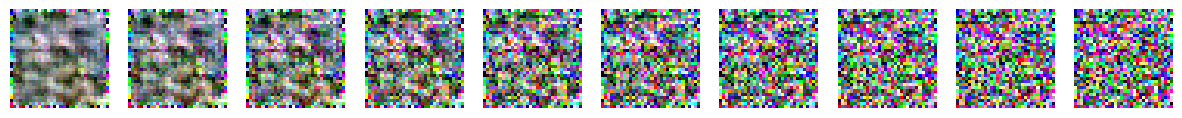

Epoch 200 Loss: 0.13375549018383026
Epoch 300 Loss: 0.08013628423213959
Epoch 400 Loss: 0.11639462411403656
Epoch 500 Loss: 0.3328838348388672
Epoch 600 Loss: 0.06695849448442459
Epoch 700 Loss: 0.039043303579092026
Epoch 800 Loss: 0.8030475378036499
Epoch 900 Loss: 0.07446932047605515
Epoch 1000 Loss: 0.02977708727121353


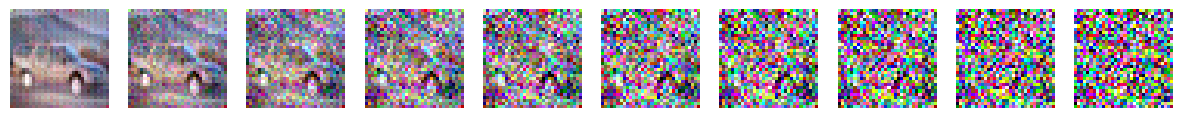

Epoch 1100 Loss: 0.0239761620759964
Epoch 1200 Loss: 0.031495802104473114
Epoch 1300 Loss: 0.027071526274085045
Epoch 1400 Loss: 0.0303606279194355
Epoch 1500 Loss: 0.022320087999105453
Epoch 1600 Loss: 0.035646744072437286
Epoch 1700 Loss: 0.03616567701101303
Epoch 1800 Loss: 0.031393516808748245
Epoch 1900 Loss: 0.036241061985492706
Epoch 2000 Loss: 0.02734839916229248
Epoch 2100 Loss: 0.04473891109228134
Epoch 2200 Loss: 0.017847461625933647
Epoch 2300 Loss: 0.026037152856588364
Epoch 2400 Loss: 0.019087638705968857
Epoch 2500 Loss: 0.0260515958070755
Epoch 2600 Loss: 0.04434218257665634
Epoch 2700 Loss: 0.14887051284313202
Epoch 2800 Loss: 0.017108578234910965
Epoch 2900 Loss: 0.066695436835289
Epoch 3000 Loss: 0.01499062217772007
Epoch 3100 Loss: 0.05446808040142059
Epoch 3200 Loss: 0.025859376415610313
Epoch 3300 Loss: 0.014294657856225967
Epoch 3400 Loss: 0.024944569915533066
Epoch 3500 Loss: 0.05634031817317009
Epoch 3600 Loss: 0.018237892538309097
Epoch 3700 Loss: 0.0182931609

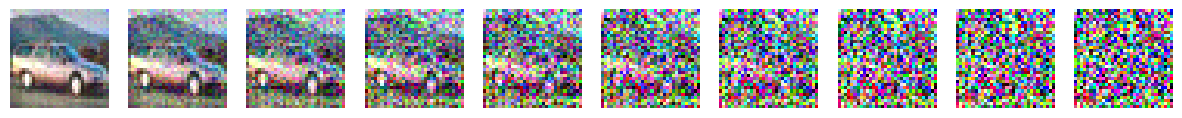

Epoch 5100 Loss: 0.015205885283648968
Epoch 5200 Loss: 0.018261946737766266
Epoch 5300 Loss: 0.020497534424066544
Epoch 5400 Loss: 0.01835654489696026
Epoch 5500 Loss: 0.018854521214962006
Epoch 5600 Loss: 0.01000194251537323
Epoch 5700 Loss: 0.01077626645565033
Epoch 5800 Loss: 0.02544832043349743
Epoch 5900 Loss: 0.043070778250694275
Epoch 6000 Loss: 0.015007279813289642
Epoch 6100 Loss: 0.04613253101706505
Epoch 6200 Loss: 0.012243404053151608
Epoch 6300 Loss: 0.07362328469753265
Epoch 6400 Loss: 0.032835084944963455
Epoch 6500 Loss: 0.013224860653281212
Epoch 6600 Loss: 0.006563182920217514
Epoch 6700 Loss: 0.009666068479418755
Epoch 6800 Loss: 0.00872945785522461
Epoch 6900 Loss: 0.01476124208420515
Epoch 7000 Loss: 0.02682609111070633
Epoch 7100 Loss: 0.021066740155220032
Epoch 7200 Loss: 0.01302431058138609
Epoch 7300 Loss: 0.011718596331775188
Epoch 7400 Loss: 0.010744225233793259
Epoch 7500 Loss: 0.015211950056254864
Epoch 7600 Loss: 0.022985901683568954
Epoch 7700 Loss: 0.020

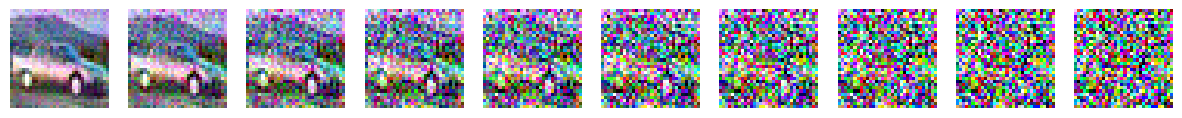

Epoch 10100 Loss: 0.01089721079915762
Epoch 10200 Loss: 0.019637426361441612
Epoch 10300 Loss: 0.011539354920387268
Epoch 10400 Loss: 0.010326378047466278
Epoch 10500 Loss: 0.008258892223238945
Epoch 10600 Loss: 0.008594231680035591
Epoch 10700 Loss: 0.020598819479346275
Epoch 10800 Loss: 0.009778471663594246
Epoch 10900 Loss: 0.01015145517885685
Epoch 11000 Loss: 0.014894858002662659
Epoch 11100 Loss: 0.015220947563648224
Epoch 11200 Loss: 0.012623963877558708
Epoch 11300 Loss: 0.4361593425273895
Epoch 11400 Loss: 0.01372698973864317
Epoch 11500 Loss: 0.009980440139770508
Epoch 11600 Loss: 0.012884199619293213
Epoch 11700 Loss: 0.01814722642302513
Epoch 11800 Loss: 0.03251320868730545
Epoch 11900 Loss: 0.006752773653715849
Epoch 12000 Loss: 0.011190950870513916


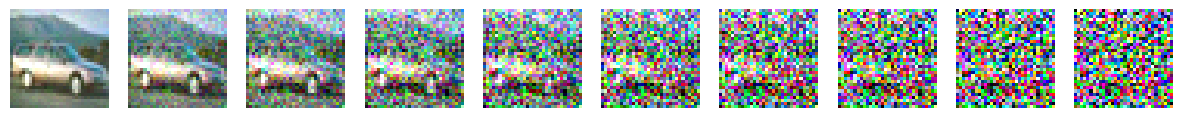

epoch,▁▂▄▇█
loss,█▁▁▁▁
epoch,12000
loss,0.01119


In [19]:
loss_history = []

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
    loss = get_loss(model, images_overfit, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"], device)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")
        
        if epoch in {100, 1000, 5000, 10_000, 12_000}:
            with torch.no_grad():
                x_gen = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model, terms["posterior_variance"])
                
                wandb.log({
                "epoch": epoch,
                "loss": loss.item(),
            })
            
wandb.finish()

In [15]:
def plot_loss(loss_history, save_path=None):
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Verlauf des Train-losses")
    plt.legend()
    
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
    plt.show()

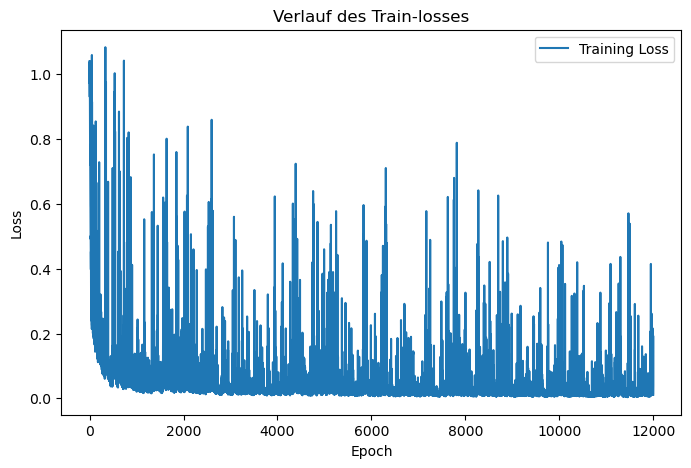

In [20]:
def plot_loss(loss_history, save_path=None):
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Verlauf des Train-losses")
    plt.legend()
    
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
    plt.show()
    
plot_loss(loss_history)

After the initial decline, the loss exhibits significant oscillations throughout the training.
These spikes suggest instability in the optimization process but is also sign for overfitting. In the following comparison we'll see a good representation of the original.

### visualize generated images and compare to original

In [21]:
def compare_images(original, generated,save_path=None):
    """
    Zeigt Original und generiertes Bild nebeneinander in einem Plot an.
    original, generated: Tensors mit Shape (C, H, W)
    """
    orig_np = denormalize_and_to_numpy(original)
    gen_np = denormalize_and_to_numpy(generated)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(orig_np)
    axs[0].set_title("Original")
    axs[0].axis("off")
    
    axs[1].imshow(gen_np)
    axs[1].set_title("Generated")
    axs[1].axis("off")
    
    #save image
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
    
    plt.show()

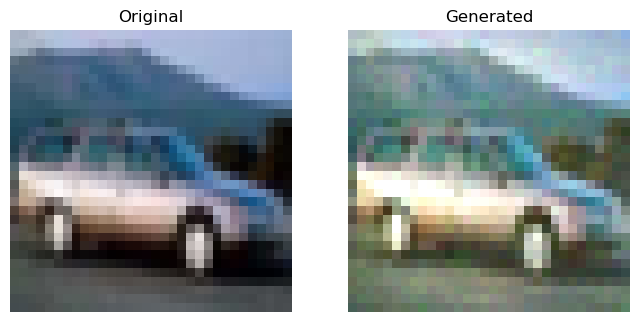

In [22]:
compare_images(images_overfit[0], x_gen[0][0].squeeze())

### conclusion
with batchnorm the image was given a certain color tone over time (from epoch 1000 extremly red), with groupnorm I unfortunately could not prevent this either, but the accuracy of the pixels improved overall (up to epoch 10,000). What is noticeable is that the groupnorm produces a much brighter image in the first steps than with the batchnorm. After a few hundred, it evens out. A big improvement was the bigger time dimension. i changed from 32 to 64 to 128 and then to 256. the improvement from 32 to 128 was big, at 32 it had big problems to learn the structures of the image, at 64 it got better and on 128 it was really good. from 128 to 256 was the improvemnt for me not visible.

The Model can learn the structures really good. Maybe in terms of color, there could be improvements.


## train on full data from one label

in this chapter i will train a model on all data of one specific label. I decided to use cars, because it is easier for the model to learn this structures, than learn for example a cats structures.

In [24]:
model_simpleU = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model_simpleU.parameters()))
model_simpleU

Num params:  63148739


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): SiLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=256, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (gnorm1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (gnorm2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=256, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


In [25]:
T = 100
betas = linear_beta_schedule(timesteps=T)
terms = precompute_terms(betas)
model_simpleU.to(device)
optimizer = torch.optim.Adam(model_simpleU.parameters(), lr=0.001)
epochs = 1_001
BATCH_SIZE = 128

In [26]:
train_1label =get_images_by_label(trainset, 1, 5_000)
print(f"Number of images in label 1 from trainset: {len(train_1label)}")

#init dataloader
trainloader_1label = torch.utils.data.DataLoader(train_1label, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Number of images in label 1 from trainset: 5000


In [27]:
wandb.init(project="simpleDiffusion", entity="floowbaumgartner", name="one_label_bs128_lr1e-3_tdim256_t100")

  0%|          | 0/1001 [00:00<?, ?it/s]

Epoch 0 Loss: 0.22889018058776855
Epoch 10 Loss: 0.14059188961982727


/tmp/ipykernel_94/1162404016.py:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


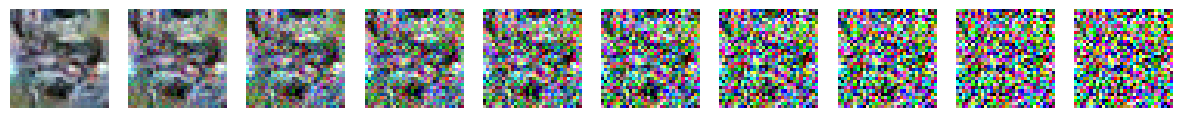

Epoch 20 Loss: 0.11240895837545395
Epoch 30 Loss: 0.1331213265657425
Epoch 40 Loss: 0.12026900053024292
Epoch 50 Loss: 0.11780490726232529


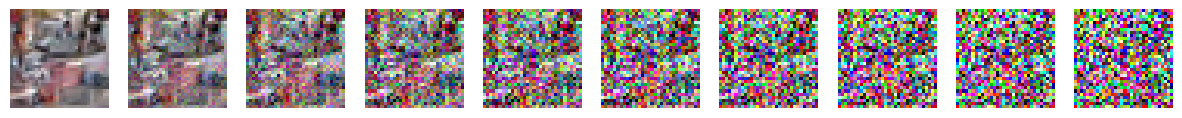

Epoch 60 Loss: 0.1078411340713501
Epoch 70 Loss: 0.11534708738327026


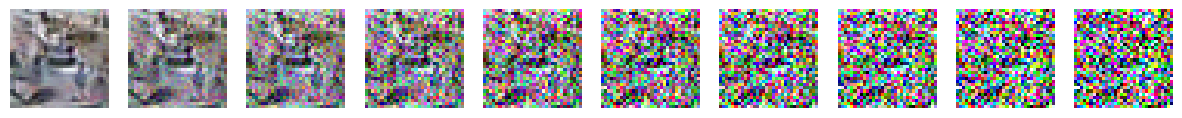

Epoch 80 Loss: 0.11303180456161499
Epoch 90 Loss: 0.1050153374671936


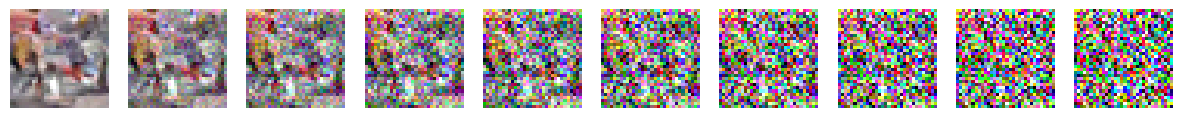

Epoch 100 Loss: 0.11805572360754013


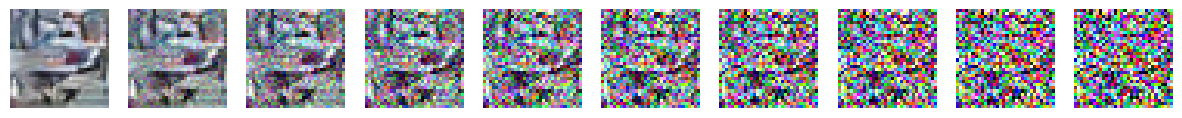

Epoch 110 Loss: 0.12148400396108627
Epoch 120 Loss: 0.11968453973531723
Epoch 130 Loss: 0.10965370386838913
Epoch 140 Loss: 0.09498967975378036
Epoch 150 Loss: 0.11974148452281952
Epoch 160 Loss: 0.1136566624045372
Epoch 170 Loss: 0.12609395384788513
Epoch 180 Loss: 0.10174113512039185
Epoch 190 Loss: 0.10222336649894714
Epoch 200 Loss: 0.09922011941671371


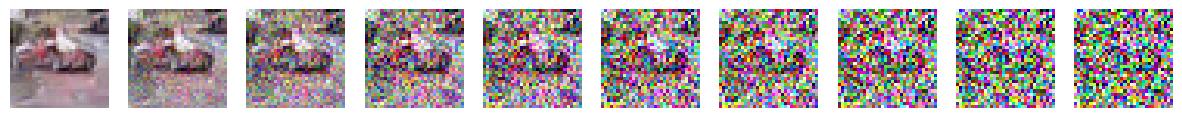

Epoch 210 Loss: 0.10875511169433594
Epoch 220 Loss: 0.08940915763378143
Epoch 230 Loss: 0.09634853899478912
Epoch 240 Loss: 0.09725339710712433
Epoch 250 Loss: 0.10900163650512695
Epoch 260 Loss: 0.11524158716201782
Epoch 270 Loss: 0.09733366966247559
Epoch 280 Loss: 0.10442128032445908
Epoch 290 Loss: 0.08808287233114243


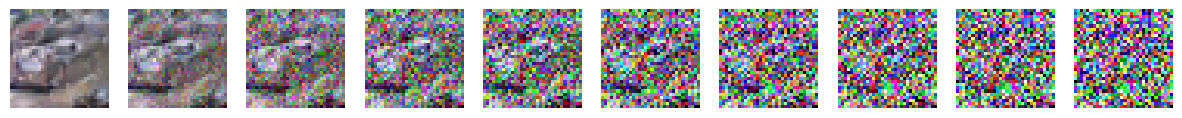

Epoch 300 Loss: 0.08518658578395844


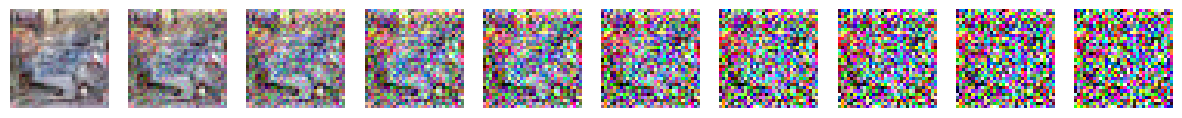

Epoch 310 Loss: 0.08503075689077377
Epoch 320 Loss: 0.09002448618412018
Epoch 330 Loss: 0.0811404138803482
Epoch 340 Loss: 0.08668472617864609
Epoch 350 Loss: 0.07341556251049042
Epoch 360 Loss: 0.09481598436832428
Epoch 370 Loss: 0.08407413959503174
Epoch 380 Loss: 0.09639404714107513
Epoch 390 Loss: 0.103492870926857
Epoch 400 Loss: 0.09558209031820297
Epoch 410 Loss: 0.07708993554115295
Epoch 420 Loss: 0.0866643488407135
Epoch 430 Loss: 0.08729268610477448
Epoch 440 Loss: 0.07989618927240372
Epoch 450 Loss: 0.07065977156162262
Epoch 460 Loss: 0.0841863602399826
Epoch 470 Loss: 0.07928597927093506
Epoch 480 Loss: 0.08178965747356415
Epoch 490 Loss: 0.07452502101659775
Epoch 500 Loss: 0.07362523674964905


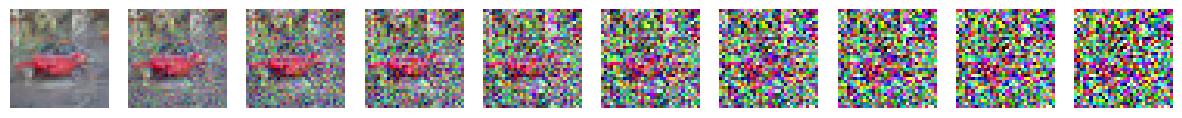

Epoch 510 Loss: 0.09072244167327881
Epoch 520 Loss: 0.09500369429588318
Epoch 530 Loss: 0.08559645712375641
Epoch 540 Loss: 0.07377997785806656
Epoch 550 Loss: 0.07873238623142242
Epoch 560 Loss: 0.06772061437368393
Epoch 570 Loss: 0.07251417636871338
Epoch 580 Loss: 0.07732648402452469
Epoch 590 Loss: 0.06650862842798233
Epoch 600 Loss: 0.07978974282741547
Epoch 610 Loss: 0.08007567375898361
Epoch 620 Loss: 0.08600344508886337
Epoch 630 Loss: 0.07613152265548706
Epoch 640 Loss: 0.06591163575649261
Epoch 650 Loss: 0.08206136524677277
Epoch 660 Loss: 0.07345403730869293
Epoch 670 Loss: 0.08353724330663681
Epoch 680 Loss: 0.08672647178173065
Epoch 690 Loss: 0.05846034735441208
Epoch 700 Loss: 0.060718998312950134
Epoch 710 Loss: 0.05775943398475647
Epoch 720 Loss: 0.06690841168165207
Epoch 730 Loss: 0.073581263422966
Epoch 740 Loss: 0.06490723043680191
Epoch 750 Loss: 0.0721275806427002
Epoch 760 Loss: 0.10373222827911377
Epoch 770 Loss: 0.075118288397789
Epoch 780 Loss: 0.07726484537124

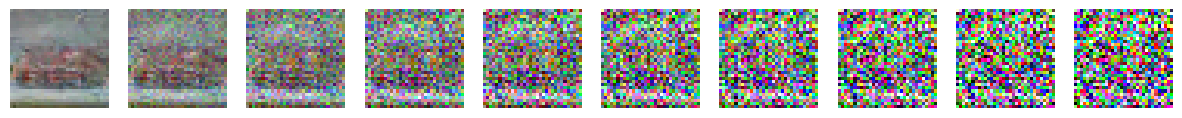

Epoch 810 Loss: 0.07176133990287781
Epoch 820 Loss: 0.06226445734500885
Epoch 830 Loss: 0.0740165114402771
Epoch 840 Loss: 0.07387463003396988
Epoch 850 Loss: 0.07477673888206482
Epoch 860 Loss: 0.06906218081712723
Epoch 870 Loss: 0.04224387928843498
Epoch 880 Loss: 0.07439182698726654
Epoch 890 Loss: 0.08724714815616608
Epoch 900 Loss: 0.060381196439266205


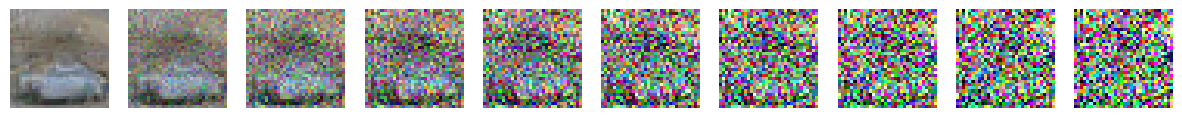

Epoch 910 Loss: 0.06349340081214905
Epoch 920 Loss: 0.06026887893676758
Epoch 930 Loss: 0.0651313066482544
Epoch 940 Loss: 0.06701932102441788
Epoch 950 Loss: 0.05801123008131981
Epoch 960 Loss: 0.06634350121021271
Epoch 970 Loss: 0.05868421494960785
Epoch 980 Loss: 0.06755928695201874
Epoch 990 Loss: 0.05416572839021683


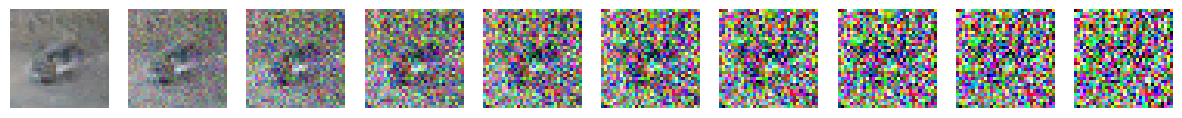

Epoch 1000 Loss: 0.05213070660829544


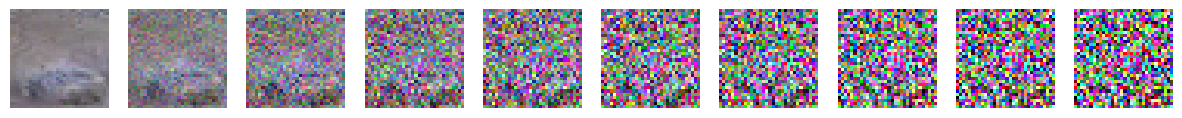

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
loss,█▇▇▆██▆▆▇▅▇▄▄▅▄▄▆▄▃▄▄▃▃▄▂▄▃▄▄▂▃▂▃▂▃▃▅▂▂▁
epoch,1000
loss,0.05213


In [28]:
loss_history_1label = []

for epoch in tqdm(range(epochs)):
    model_simpleU.train()
    for i, data in enumerate(trainloader_1label):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model_simpleU, data, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"], device)
        loss.backward()
        optimizer.step()
        loss_history_1label.append(loss.item())
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")
        
        if epoch in {10, 50, 70, 90, 100, 200, 290, 300, 500, 800, 900, 990, 1000}:
            with torch.no_grad():
                x_gen = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_simpleU, terms["posterior_variance"])
                
        wandb.log({
        "epoch": epoch,
        "loss": loss.item(),
    })
                
wandb.finish()

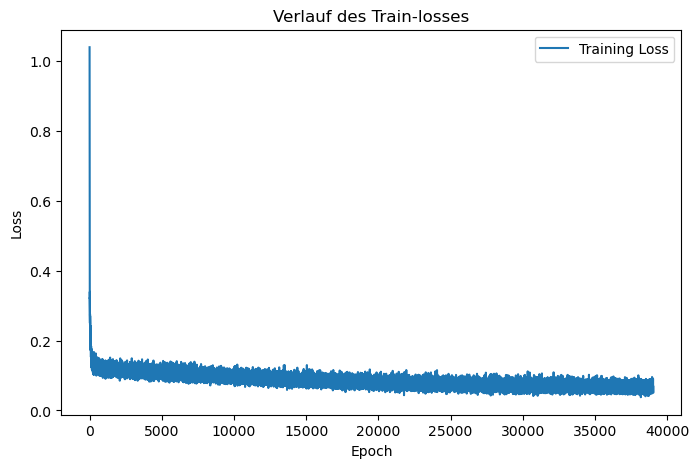

In [29]:
plot_loss(loss_history_1label)

The plot indicates successful training of the diffusion model, with rapid convergence and stable loss over time. Because of a wrong indention in the code, the epochs were logged in every batch. This is why ther are almost 40'000 logs in the plot. The acutal number of Epochs were 1'001.

### visualize generated images and compare to original

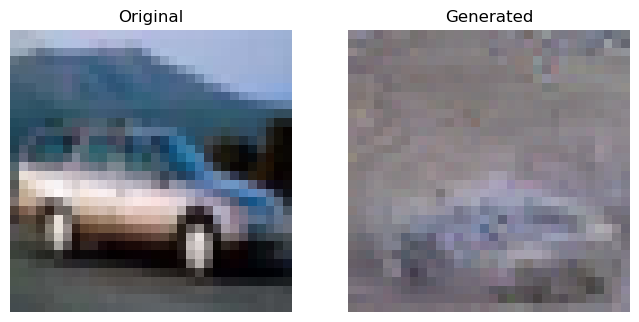

In [30]:
compare_images(train_1label[0], x_gen[0][0].squeeze())

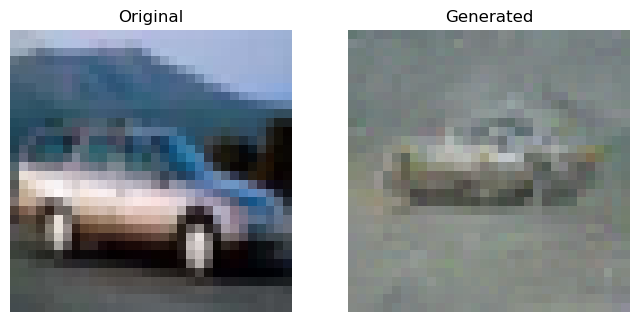

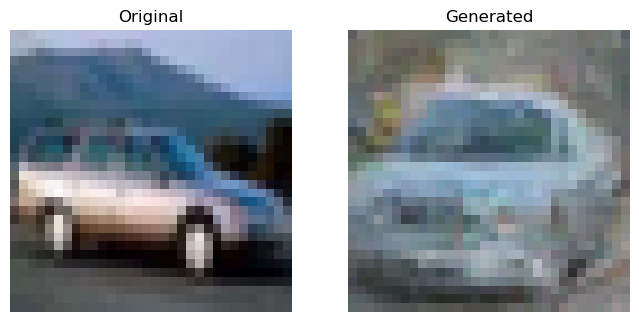

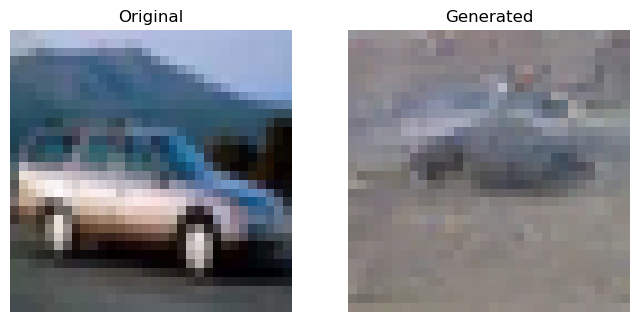

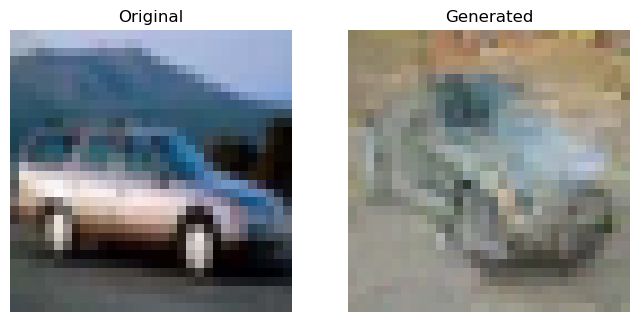

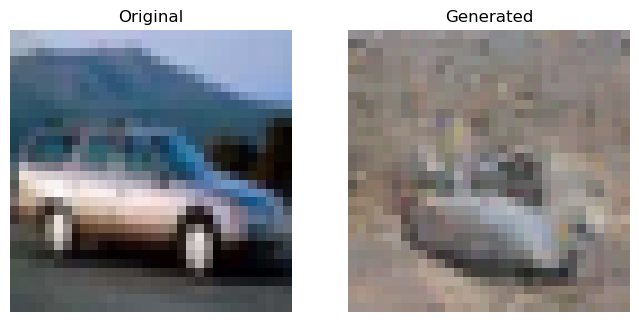

In [31]:
x_gen_1label_list = []
with torch.no_grad():
    for i in range(5):
        x_gen_1label = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_simpleU, terms["posterior_variance"], visualize=False)
        x_gen_1label_list.append(x_gen_1label)

for x_gen in x_gen_1label_list:
    compare_images(train_1label[0], x_gen[0][0].squeeze())

Some of the generated images look really good, but there are others, that just look not like a car.

### FID Score

The Fréchet Inception Distance (FID) is a widely-used metric in generative modeling, particularly for evaluating the quality of generated images.
So i decided to use the FID to evaluate my models. It measures the similarity between the distribution of real images and generated images in the feature space of a pretrained neural network.

The FID score is calculated as:

$$
\text{FID} = \|\mu_r - \mu_g\|^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2})
$$

---
i save 1'000 generated pictures and 1'000 real pictures from the testset of the cifar10 dataset to evaluate the generated pictures.
If i take more pictures to compare i shout get a preciser FID score.

In [32]:
gen_1label_dir = './data/generated_1label'
real_1label_dir = './data/real_1label'
os.makedirs(gen_1label_dir, exist_ok=True)
os.makedirs(real_1label_dir, exist_ok=True)

In [17]:
def save_gen_imgs(gen_dir,gen_images,name:str,label=None): 
    for i in range(len(gen_images)):
        for x_gen in gen_images:
            x_gen = denormalize_and_to_numpy(x_gen[i][0].squeeze())
            x_gen = torch.tensor(x_gen).permute(2,0,1)
            
            if label is not None:
                gen_dir = os.path.join(gen_dir, f'label_{label}')
                os.makedirs(gen_dir, exist_ok=True)
                
            vutils.save_image(
                x_gen, 
                os.path.join(gen_dir, f'gen_{name}.png')
            )
            

In [34]:
num_gen_imgs = 1_000

# Generate and save images
with torch.no_grad():
    for i in range(num_gen_imgs):
        x_gen_1label = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_simpleU, terms["posterior_variance"], visualize=False)
        save_gen_imgs(gen_1label_dir, x_gen_1label, i)

/tmp/ipykernel_94/2834134599.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen = torch.tensor(x_gen).permute(2,0,1)


In [18]:
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

Files already downloaded and verified


In [36]:
# select the same label for the testset because the model was trained on this label
selected_label = 0

# find Indices of the label in testset
selected_indices = [i for i, label in enumerate(testset.targets) if label == selected_label]

# make subset
testset_1label = Subset(testset, selected_indices)

In [37]:
#save real images
# for i in range(num_gen_imgs):
#    img, label = testset_1label[i]
#    vutils.save_image(
#        img, 
#        os.path.join(real_1label_dir, f'real_{i}.png')
#    )

In [56]:
def calc_fid(real_dir, gen_dir):
    #calc fid score
    metrics_dict = calculate_metrics(
        input1=real_dir,
        input2=gen_dir,
        cuda=torch.cuda.is_available(),  
        isc=False,  # Inception Score not needed
        fid=True,   # FID needed
        kid=False,  
        verbose=True
    )
    
    print("FID Score:", metrics_dict["frechet_inception_distance"])


In [39]:
calc_fid(real_1label_dir, gen_1label_dir)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "./data/real_1label" with extensions png,jpg,jpeg
Found 1000 samples
/home/.local/lib/python3.10/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                          
Extracting statistics from input 2
Looking for samples non-recursivelty in "./data/generated_1label" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples                                                          


FID Score: 187.38393818348567


Frechet Inception Distance: 187.38393818348567


The FID-Score is really high. A good score would be under 50, my score is over 180.

### conclusion

With over 1'000 Epochs, the model was able to learn the structures of the cars really well. But some of the generated images look good and some of them look bad. The FID score is really high, which indicates that the generated images are not very similar to the real images. The model could be improved by upgrading the Unet architecture and make it more complex. The Arcitecture used in the DDIM is a lot more complex than my simple Unet and could therefore be an upgrade.

### save model

In [42]:
# Save params
checkpoint = {
    "epoch": epochs,
    "model_state_dict": model_simpleU.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": loss
}

torch.save(checkpoint, "checkpoint_simpleU.pt")

In [43]:
#save model
torch.save(model_simpleU, "SimpleU_entire_model.pth")

## train on full data from all labels

In the next task, i train the model with full trainset from all labels. The model should learn the structures of all labels and generate images from all labels.

In [35]:
model_simpleU_all = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model_simpleU_all.parameters()))
model_simpleU_all

Num params:  63148739


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): SiLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=256, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (gnorm1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (gnorm2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=256, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


In [36]:
T = 100
betas = linear_beta_schedule(timesteps=T)
terms = precompute_terms(betas)
model_simpleU_all.to(device)
optimizer = torch.optim.Adam(model_simpleU_all.parameters(), lr=0.001)
epochs = 501
BATCH_SIZE = 64

In [19]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [38]:
wandb.init(project="simpleDiffusion", entity="floowbaumgartner", name="all_labels_bs64_lr1e-3_tdim256_t100_b501")

  0%|          | 0/501 [00:00<?, ?it/s]

Epoch 0 Loss: 0.12960894405841827
Epoch 10 Loss: 0.09097188711166382


/tmp/ipykernel_73/1162404016.py:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


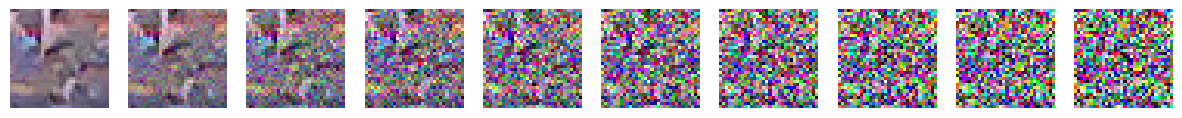

Epoch 20 Loss: 0.12232335656881332
Epoch 30 Loss: 0.10668371617794037
Epoch 40 Loss: 0.10409258306026459
Epoch 50 Loss: 0.0940622091293335
Epoch 60 Loss: 0.08396285027265549
Epoch 70 Loss: 0.09213139861822128
Epoch 80 Loss: 0.10479729622602463
Epoch 90 Loss: 0.09261496365070343
Epoch 100 Loss: 0.08057763427495956


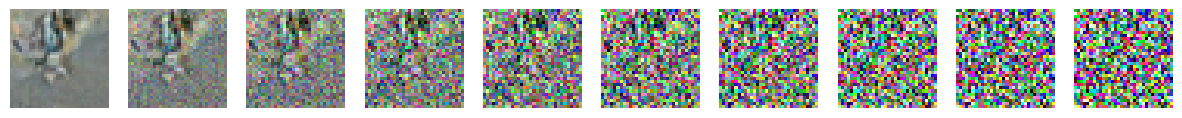

Epoch 110 Loss: 0.0802941843867302
Epoch 120 Loss: 0.1038150042295456
Epoch 130 Loss: 0.07957001030445099
Epoch 140 Loss: 0.08357754349708557
Epoch 150 Loss: 0.07028993219137192
Epoch 160 Loss: 0.07586988806724548
Epoch 170 Loss: 0.07471480965614319
Epoch 180 Loss: 0.1107884868979454
Epoch 190 Loss: 0.11760743707418442
Epoch 200 Loss: 0.11307679861783981


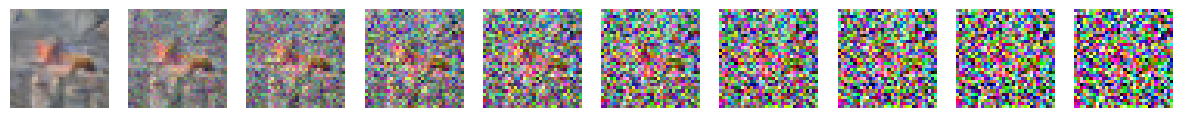

Epoch 210 Loss: 0.06760264933109283
Epoch 220 Loss: 0.08186006546020508
Epoch 230 Loss: 0.07530442625284195
Epoch 240 Loss: 0.08349339663982391
Epoch 250 Loss: 0.08638080954551697
Epoch 260 Loss: 0.08214428275823593
Epoch 270 Loss: 0.08908926695585251
Epoch 280 Loss: 0.08567064255475998
Epoch 290 Loss: 0.09220966696739197
Epoch 300 Loss: 0.08599647134542465


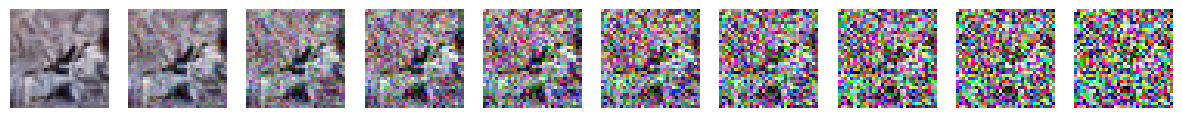

Epoch 310 Loss: 0.09302615374326706
Epoch 320 Loss: 0.09275498241186142
Epoch 330 Loss: 0.11249195784330368
Epoch 340 Loss: 0.1095084398984909
Epoch 350 Loss: 0.0897410660982132
Epoch 360 Loss: 0.08173021674156189
Epoch 370 Loss: 0.10931703448295593
Epoch 380 Loss: 0.08161840587854385
Epoch 390 Loss: 0.07857336103916168
Epoch 400 Loss: 0.09525406360626221
Epoch 410 Loss: 0.07997164130210876
Epoch 420 Loss: 0.08461089432239532
Epoch 430 Loss: 0.06998778879642487
Epoch 440 Loss: 0.11395838111639023
Epoch 450 Loss: 0.10326926410198212
Epoch 460 Loss: 0.09801116585731506
Epoch 470 Loss: 0.08858992904424667
Epoch 480 Loss: 0.10482637584209442
Epoch 490 Loss: 0.07033239305019379
Epoch 500 Loss: 0.09741972386837006


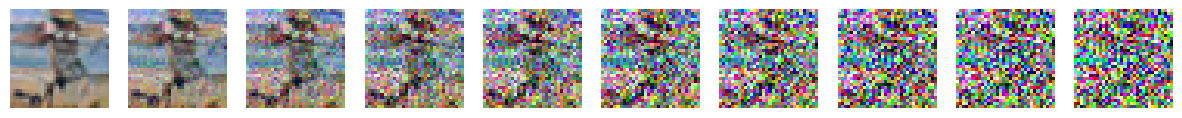

epoch,█▆▅▄▄▄▄▄▄▃▃▃▃▂▃▂▂▃▂▂▂▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
loss,▆▆▄▇▆▃▄▆▄▇▃▆▅█▃▇▄▆▅▂▅▄▁▆▃▆▄▅▅▆▃▅▃▄▄▃▄▅▇▇
epoch,0.08713
loss,0.09742


In [39]:
loss_history_all = []
for epoch in tqdm(range(epochs)):
    model_simpleU_all.train()
    epoch_loss = 0
    for i, (data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model_simpleU_all, data, t, terms["sqrt_alphas_cumprod"],
                        terms["sqrt_one_minus_alphas_cumprod"], device)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()


    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")

        if epoch in {10, 100, 200, 300, 500, 700, 900, 1000}:
            with torch.no_grad():
                x_gen = sample_plot_image(T, terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas,
                                          model_simpleU_all, terms["posterior_variance"])

    epoch_loss /= len(trainloader)
    loss_history_all.append(epoch_loss)
    wandb.log({
        "epoch": epoch_loss,
        "loss": loss.item(),
    })

wandb.finish()

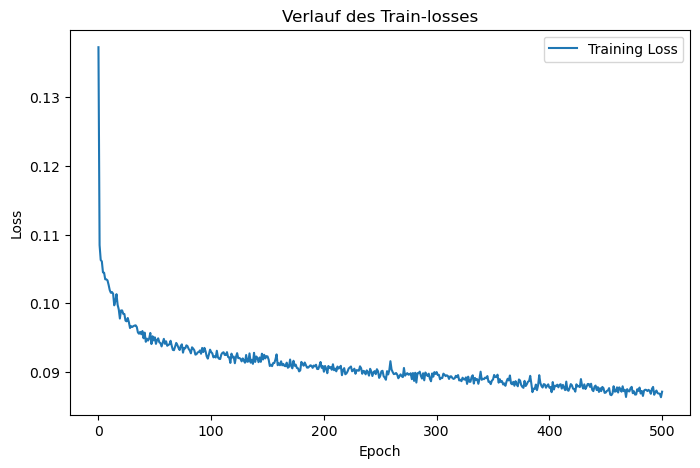

In [40]:
plot_loss(loss_history_all, save_path="loss_all_labels_1000.png")

In [45]:
checkpoint = {
    "epoch": epochs,
    "model_state_dict": model_simpleU_all.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": loss
}

torch.save(checkpoint, "checkpoint_simpleU_all_v2.pt")
#%%
#save model
torch.save(model_simpleU_all, "SimpleU_entire_model_all_v2.pth")

### visualize generated images and compare to original

In [ ]:
import torch # TODO: löschen

SimpleU_entire_model_all = torch.load("./models/SimpleU_entire_model_all_v2.pth",weights_only=False)
T = 100

# Setze das Modell in den Evaluierungsmodus
SimpleU_entire_model_all.eval()
betas = linear_beta_schedule(timesteps=T)
terms = precompute_terms(betas)

x_gen_alllabel = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, SimpleU_entire_model_all, terms["posterior_variance"], visualize=False)

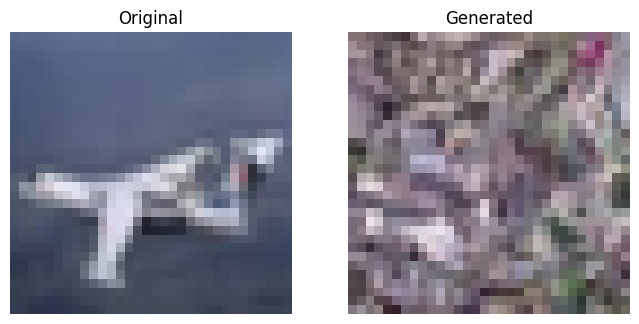

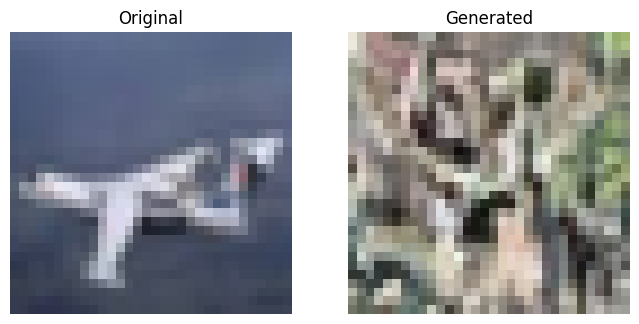

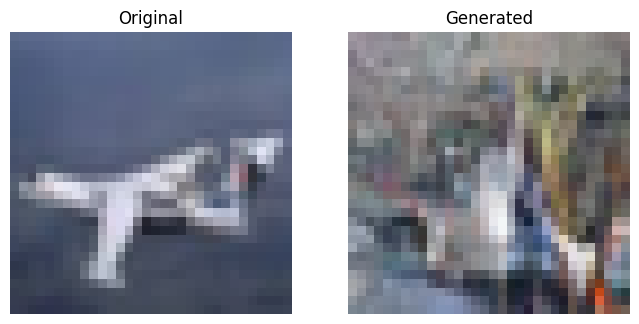

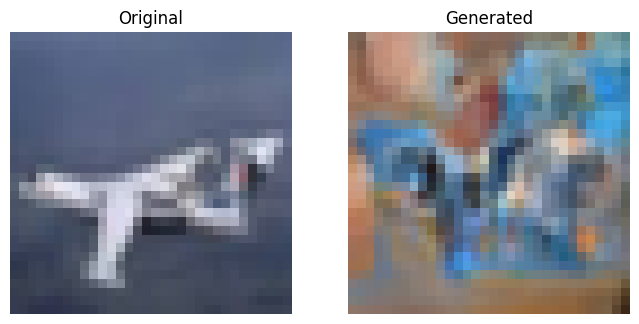

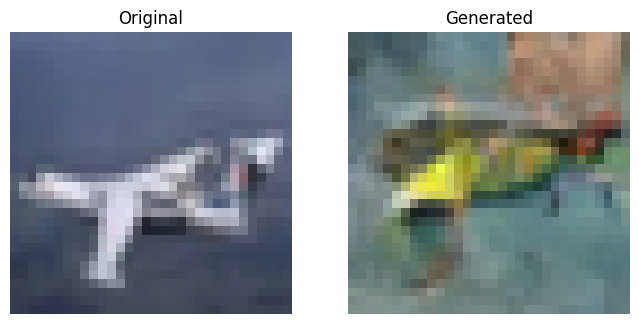

In [54]:
img_orig, label = trainloader.dataset[10_987]
x_gen_alllabel_list = []
with torch.no_grad():
    for i in range(5):
        x_gen_alllabel = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, SimpleU_entire_model_all, terms["posterior_variance"], visualize=False)
        x_gen_alllabel_list.append(x_gen_alllabel)

for x_gen in x_gen_alllabel_list:
    compare_images(img_orig, x_gen[0][0].squeeze())

The genetrated images are very hard to interpret. The model was not able to learn the structures of all labels. it is hard for the model because a conditional input is missing. The model was trained on all labels, but the model was not able to learn the structures of the diffrent labels. For sure i need more epochs, because now, it was trained on just 501 epochs and it took already 6 hours on slurm. 
 The FID score will show how 'good' the model is.

### FID Score

In [55]:
gen_dir = './data/generated_alllabel'
real_dir = './data/real'
os.makedirs(gen_dir, exist_ok=True)
os.makedirs(real_dir, exist_ok=True)

In [44]:
num_gen_imgs = 1_000

# Generate and save images
with torch.no_grad():
    for i in range(num_gen_imgs):
        x_gen_all = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_simpleU_all, terms["posterior_variance"], visualize=False)
        save_gen_imgs(gen_dir,x_gen_all, i)

/tmp/ipykernel_73/2834134599.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen = torch.tensor(x_gen).permute(2,0,1)


In [54]:
testloader_fid = torch.utils.data.DataLoader(testset, batch_size=num_gen_imgs, shuffle=True)

# save real images
# for i in range(num_gen_imgs):
#     img, label = testloader_fid.dataset[i]
#     vutils.save_image(
#         img, 
#         os.path.join(real_dir, f'real_{i}.png')
#    )

In [57]:
calc_fid(real_dir, gen_dir)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "./data/real" with extensions png,jpg,jpeg
Found 1000 samples
C:\Users\flori\Documents\BSc_Data-Science_FHNW\Module\VDL\cifar10_imgGeneration\venv\Lib\site-packages\torch_fidelity\datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                           
Extracting statistics from input 2
Looking for samples non-recursivelty in "./data/generated_alllabel" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples                               

FID Score: 143.49575716220693


Frechet Inception Distance: 143.49575716220693


### conclusion

The FID-score shows, that this model has a better FID score than the one that was trained on just one label. But visualy the images are not good. The model was not able to learn the structures of different label-images, also because the conditional input is missing. So it learns a mix of all the labels combined. For sure i need more epochs, it was trained on just 501 epochs, but i think even 1'000 epoch wouldn't change the resulting images much. sadly i had not more time to train the model on more epochs until my deadline.
To hoefully get a better output i now try to train a conditional diffusion model.

# conditonal diffusion model
the big addition in this model is the conditional input. The model should learn the structures of the diffrent labels and generate images from all labels. If `num_classes` is specified, this module embeds class labels into the same dimensional space as the time embedding, enabling conditional behavior based on the input label.  Therefore, in the forward pass, if label `y` is provided, the corresponding embedding (`label_emb(y)`) is added onto the time embedding.

In [47]:
class ConditionalUnet(nn.Module):
    """
    A simple variant of the Unet architecture.
    """
    def __init__(self, num_classes=None):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 128 # tried 32,64,128,256
        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.SiLU() #changed from Relu to SiLU -> SiLU is a smooth version of ReLU and is good for diffusion models because can avoid dead neurons and smoother than ReLU. (but calculation takes longer)
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        # Output
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)
        
        # Conditional classes
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_emb_dim)


    def forward(self, x, timestep, y):
        # Embedd time
        t = self.time_mlp(timestep)
        
        #conditional
        if y is not None:
            t += self.label_emb(y)
        
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

## overfittest
I test the model with 2 pictures of 2 diffrent labels. The model will learn the structures of these 2 labels and will overfit on these 2 pictures.

In [58]:
num_classes = 2
model_cond = ConditionalUnet(num_classes=num_classes)
print("Num params: ", sum(p.numel() for p in model_cond.parameters()))
model_cond

Num params:  63149251


ConditionalUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): SiLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=256, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (gnorm1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (gnorm2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=256, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1,

In [59]:
T = 100
betas = linear_beta_schedule(timesteps=T)
terms = precompute_terms(betas)
model_cond.to(device)
optimizer = torch.optim.Adam(model_cond.parameters(), lr=0.001)
epochs = 5_001
BATCH_SIZE = 2

In [60]:
desired_labels = [0, 1]  
desired_indices = []

# go through the dataset and pick the first image for each desired label
found_labels = set()

for idx, (_, label) in enumerate(trainset):
    if label in desired_labels and label not in found_labels:
        desired_indices.append(idx)
        found_labels.add(label)
    # Stop if found at least one sample for each desired label
    if len(found_labels) == len(desired_labels):
        break

#Create a Subset
trainset_cond_subset = Subset(trainset, desired_indices)

In [61]:
trainloader_cond_subset = torch.utils.data.DataLoader(trainset_cond_subset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
wandb.init(project="Conditional-Diffusion", entity="floowbaumgartner", name="overfit_2labels_lr1e-3_tdim256_t100")

  0%|          | 0/5001 [00:00<?, ?it/s]

Epoch 0 Loss: 1.0324203968048096
Epoch 100 Loss: 0.27670612931251526


/tmp/ipykernel_94/1162404016.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


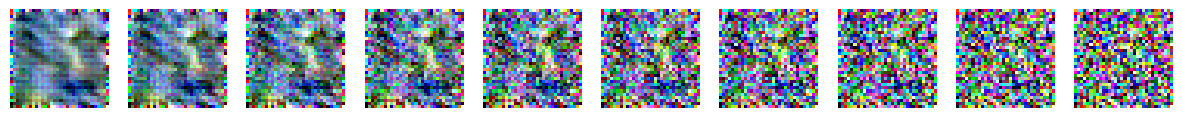

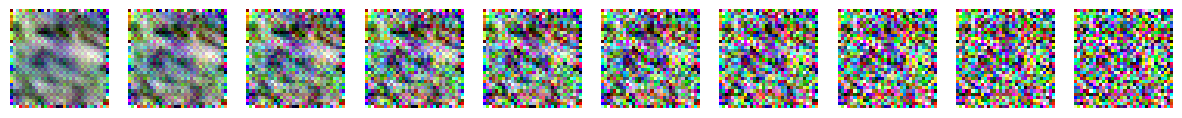

Epoch 200 Loss: 0.16404248774051666


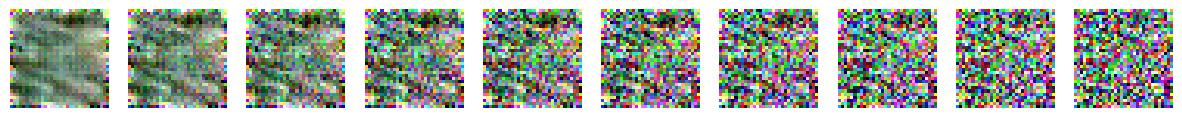

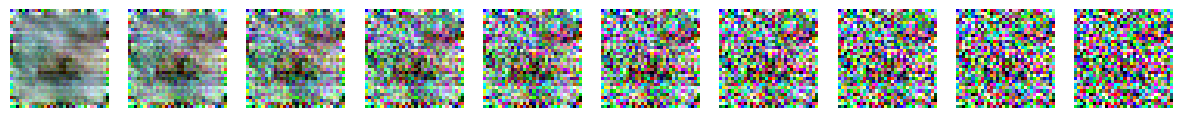

Epoch 300 Loss: 0.19328276813030243
Epoch 400 Loss: 0.06954064220190048
Epoch 500 Loss: 0.0556911826133728


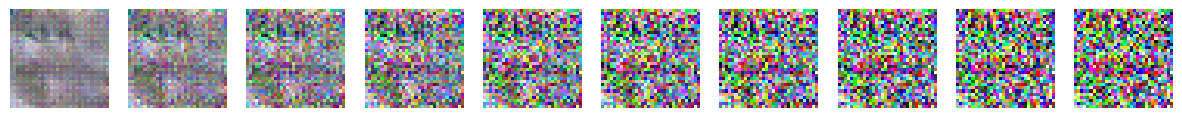

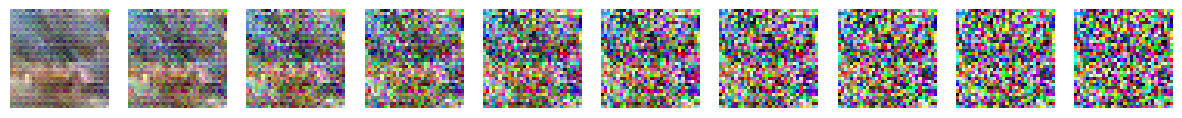

Epoch 600 Loss: 0.05825363099575043
Epoch 700 Loss: 0.03606170415878296


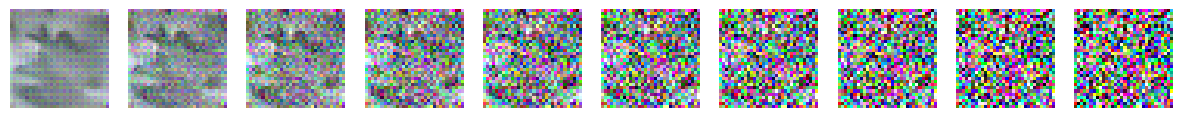

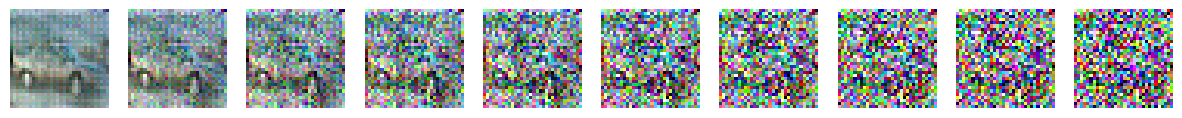

Epoch 800 Loss: 0.03037126362323761
Epoch 900 Loss: 0.03787114843726158
Epoch 1000 Loss: 0.04979187250137329


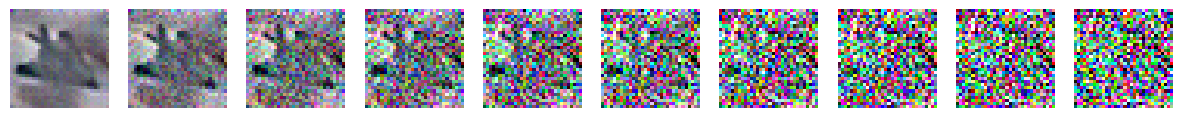

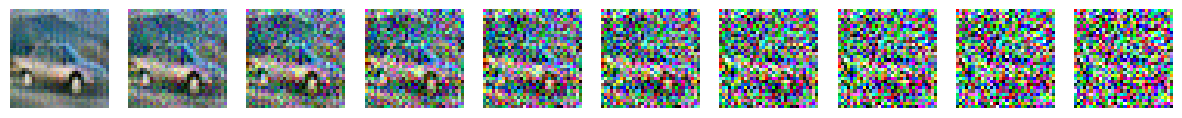

Epoch 1100 Loss: 0.04428233951330185
Epoch 1200 Loss: 0.04287678003311157
Epoch 1300 Loss: 0.05008305236697197
Epoch 1400 Loss: 0.10526774823665619
Epoch 1500 Loss: 0.03437235206365585
Epoch 1600 Loss: 0.03284459188580513
Epoch 1700 Loss: 0.0186842679977417
Epoch 1800 Loss: 0.021597251296043396
Epoch 1900 Loss: 0.02090223878622055
Epoch 2000 Loss: 0.01850753463804722


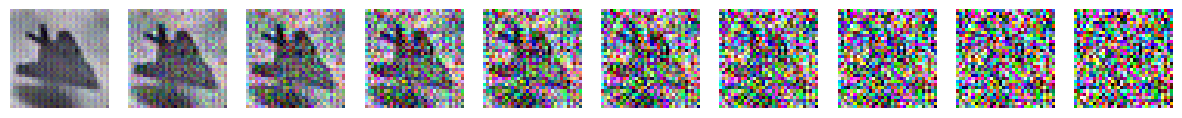

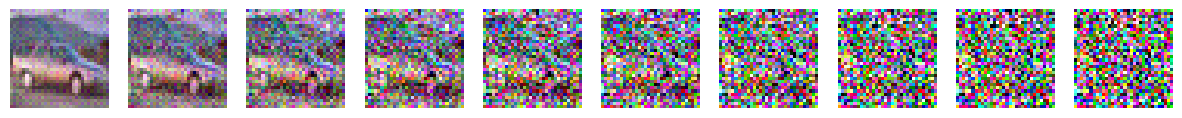

Epoch 2100 Loss: 0.022338373586535454
Epoch 2200 Loss: 0.01976035162806511
Epoch 2300 Loss: 0.019714470952749252
Epoch 2400 Loss: 0.019270766526460648
Epoch 2500 Loss: 0.07806604355573654
Epoch 2600 Loss: 0.029961876571178436
Epoch 2700 Loss: 0.040367692708969116
Epoch 2800 Loss: 0.18862369656562805
Epoch 2900 Loss: 0.08766341209411621
Epoch 3000 Loss: 0.18535356223583221


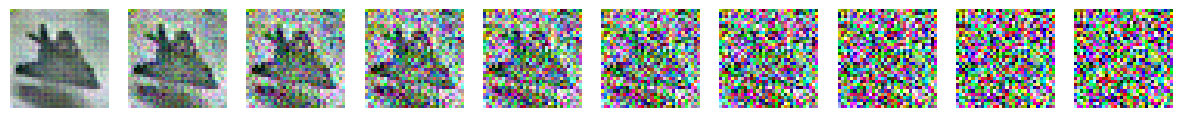

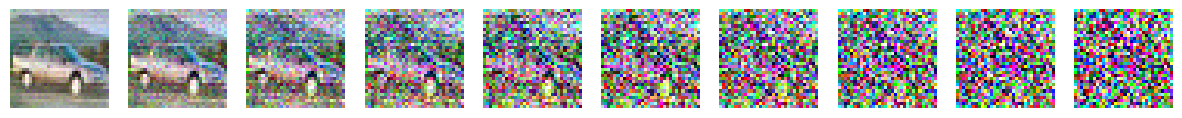

Epoch 3100 Loss: 0.025268811732530594
Epoch 3200 Loss: 0.02199362963438034
Epoch 3300 Loss: 0.013957816176116467
Epoch 3400 Loss: 0.04775361344218254
Epoch 3500 Loss: 0.03161824494600296
Epoch 3600 Loss: 0.015095934271812439
Epoch 3700 Loss: 0.013061689212918282
Epoch 3800 Loss: 0.01362927071750164
Epoch 3900 Loss: 0.07619044929742813
Epoch 4000 Loss: 0.04117721691727638


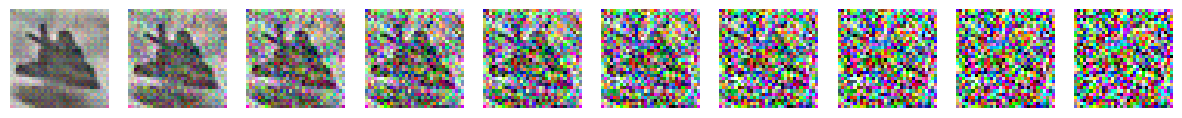

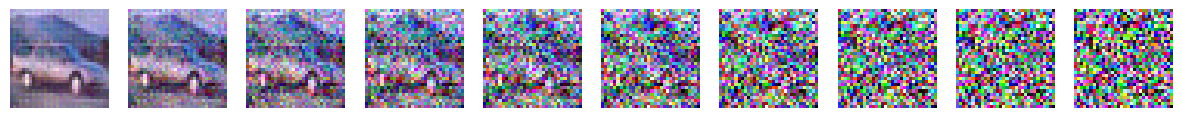

Epoch 4100 Loss: 0.01902470365166664
Epoch 4200 Loss: 0.014401587657630444
Epoch 4300 Loss: 0.012637211941182613
Epoch 4400 Loss: 0.01186536904424429
Epoch 4500 Loss: 0.01434582844376564
Epoch 4600 Loss: 0.019450588151812553
Epoch 4700 Loss: 0.11916212737560272
Epoch 4800 Loss: 0.03585278242826462
Epoch 4900 Loss: 0.018603984266519547
Epoch 5000 Loss: 0.021421728655695915


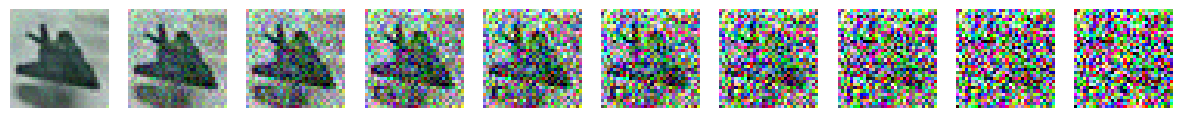

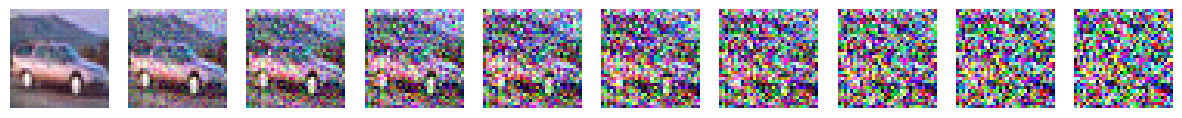

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
epoch,5000
loss,0.02142


In [62]:
loss_history_cond_oft = []

for epoch in tqdm(range(epochs)):
    model_cond.train()
    for i, (data, label) in enumerate(trainloader_cond_subset):
        optimizer.zero_grad()
        label = label.to(device)
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model_cond, data, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"], device, label)
        loss.backward()
        optimizer.step()
        loss_history_cond_oft.append(loss.item())
        
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")
        
        if epoch in {100, 200, 500, 700, 1000, 2000, 3000, 4000, 5000}:
            with torch.no_grad():
                x_gen = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_cond, terms["posterior_variance"],num_classes)
                
        wandb.log({
        "epoch": epoch,
        "loss": loss.item(),
    })
                
wandb.finish()

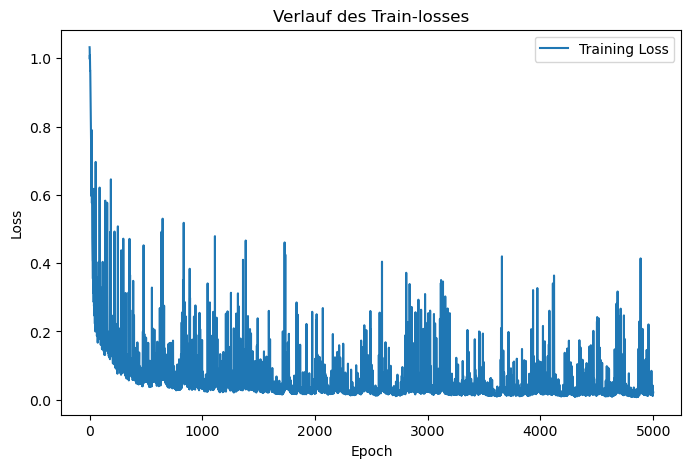

In [63]:
plot_loss(loss_history_cond_oft)

The plot indicates a successful training of the model. the big deflections in the loss will be due to the fact that the model was trained on just 2 pictures and is overfitting on them. the course of the Loss indicates that the model was able to learn the structures of the 2 labels really well.

### visualize generated images and compare to original

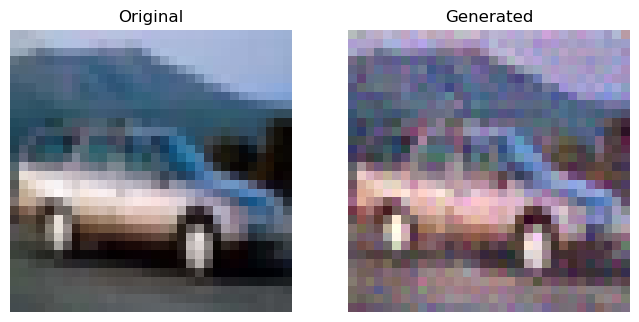

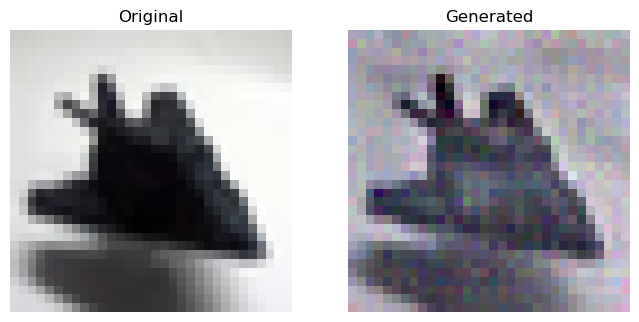

In [64]:
with torch.no_grad():
    x_gen_cond_label = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_cond, terms["posterior_variance"],num_classes=2, visualize=False, labels_default=[0,1])
    compare_images(trainloader_cond_subset.dataset[0][0], x_gen_cond_label[1][0].squeeze())
    compare_images(trainloader_cond_subset.dataset[1][0], x_gen_cond_label[0][0].squeeze())

### conclusion

The generated images look very good. The model was able to learn the structures of the 2 labels well, also the colors are really good. But they are still no perfect replicas of the original images. The model learned the structures, so my overfittest is successful. For the next step i will train the model on all labels.

## train on full data with all labels
The model gets 10 labels as input and should learn the structures of all labels and generate images from all labels.

In [49]:
num_classes = 10
model_cond_all = ConditionalUnet(num_classes=num_classes)
print("Num params: ", sum(p.numel() for p in model_cond_all.parameters()))
model_cond_all

Num params:  62732099


ConditionalUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): SiLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=128, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (gnorm1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (gnorm2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=128, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1,

In [50]:
T = 100
betas = linear_beta_schedule(timesteps=T)
terms = precompute_terms(betas)
model_cond_all.to(device)
optimizer = torch.optim.Adam(model_cond_all.parameters(), lr=0.001)
epochs = 501
BATCH_SIZE = 64

In [51]:
trainloader_cond = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [52]:
wandb.init(project="Conditional-Diffusion", entity="floowbaumgartner", name="conditional_bs64_lr1e-3_tdim128_t100_e501")

In [53]:
loss_history_cond = []
for epoch in tqdm(range(epochs)):
    model_cond_all.train()
    epoch_loss = 0
    for i, (data, label) in enumerate(trainloader_cond):
        optimizer.zero_grad()
        label = label.to(device)
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model_cond_all, data, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"],
                        device, label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()


    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")

        if epoch in {10, 50, 100, 150, 200, 300, 500, 700, 900, 1000}:
            with torch.no_grad():
                x_gen = sample_plot_image(T, terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_cond_all, terms["posterior_variance"], num_classes)

    epoch_loss /= len(trainloader_cond)
    loss_history_cond.append(epoch_loss)
    wandb.log({
        "epoch": epoch_loss,
        "loss": loss.item(),
    })

wandb.finish()

  0%|          | 0/501 [00:00<?, ?it/s]

Epoch 0 Loss: 0.10009877383708954


KeyboardInterrupt: 

In [ ]:
plot_loss(loss_history_cond, save_path="loss_cond_all_labels_.png")

In [ ]:
# Save params
checkpoint = {
    "epoch": epochs,
    "model_state_dict": model_cond_all.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": loss
}

torch.save(checkpoint, "checkpoint_simpleU_cond_all.pt")
##%%
#save model
torch.save(model_cond_all, "SimpleU_entire_model_cond_all.pth")

### visualize generated images and compare to original

In [ ]:
try:
    one_image_per_label = []
    for img_trainset, label_trainset in trainset:
        if label_trainset not in found_labels:
            found_labels.add(label_trainset)
            one_image_per_label.append((img_trainset, label_trainset))
        if len(found_labels) == 10:
            break
    
    with torch.no_grad():
        x_gen_cond = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_cond_all, terms["posterior_variance"],num_classes=10, visualize=False, labels_default=[0,1,2,3,4,5,6,7,8,9])
        for i in range(10):
            compare_images(one_image_per_label[i], x_gen_cond[i][0].squeeze())

except:
    print("Error")

### FID Score

In [ ]:
gen_cond_dir = r'.\data\generated_cond'
real_cond_dir = r'.\data\real_cond'
os.makedirs(gen_cond_dir, exist_ok=True)
os.makedirs(real_cond_dir, exist_ok=True)

In [ ]:
num_gen_imgs = 1_000

with torch.no_grad():
    for i in range(num_gen_imgs):
        for label_num in range(num_classes):
            x_gen_cond_ = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_cond_all, terms["posterior_variance"],num_classes=num_classes, visualize=False, labels_default=[label_num])
            save_gen_imgs(gen_cond_dir,x_gen_cond_, i,label=label_num)

In [ ]:
for selected_label in range(num_classes):
    real_cond_dir = real_cond_dir + f'\label_{selected_label}'
    gen_cond_dir = gen_cond_dir + f'\label_{selected_label}'
    print(gen_cond_dir)
    os.makedirs(real_cond_dir, exist_ok=True)
    # find Indices of the label in testset
    selected_indices = [i for i, label in enumerate(testset.targets) if label == selected_label]

    testset_label = Subset(testset, selected_indices)
    #save real images
    for j in range(num_gen_imgs):
        img, label = testset_label[j]
        
        vutils.save_image(
            img,
            real_cond_dir + f'real_{j}.png'
        )

    calc_fid(real_cond_dir, gen_cond_dir)

In [ ]:
calc_fid(real_cond_dir, gen_cond_dir)

### conclusion

In [ ]:
# TODO: Conclusion

# examples of generated images with different default labels

In [ ]:
# TODO: examples of generated images with different default labels

# summary
My Models work, but are not very good. it would take some time to upgrade the structure of the models and do additional finetuning to get better results. But i think i'm on the right way. 

In [ ]:
# TODo: write about bottleneck
# TODO: write about T=1000

# fragen:
TODO:
diagnostische plots -> wandb
wie testen -> qualität eines generativen modells testen